In [8]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from dateutil.parser import parse
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt

In [9]:
###TODO: expand to full data, figure out how to visualize the difference in compounds or just train multiple neural networks on each compound, fix the size error idk why thats happening

In [47]:


df = pd.read_csv('F1_4502\LapAndWeather\LapWeather_Australian Grand Prix')
df = df.drop(['Time','DriverNumber', 'Unnamed: 0', 'LapNumber', 'PitOutTime', 'PitInTime', 'Sector1Time','Sector2Time','Sector3Time','Sector1SessionTime','Sector2SessionTime','Sector3SessionTime','SpeedI1','SpeedI2','SpeedST','IsPersonalBest','FreshTyre','Stint','SpeedFL','LapStartTime','Team','Driver','TrackStatus','IsAccurate'], axis=1)
df = df.dropna()
print(df)
dfOutput = df['LapTime']
train_targets = dfOutput.to_numpy()
for i in range(len(train_targets)):
    train_targets[i] = train_targets[i].replace('0 days ', '')
actual_train_targets = []
for time in train_targets:
    td = parse(time) - parse('00:00:00')
    seconds = td.total_seconds()
    actual_train_targets.append(seconds)
dfLapTime = pd.DataFrame(actual_train_targets)
df['LapTime'] = dfLapTime
df = df.dropna()
cols = ['LapTime']
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3-Q1
df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
dfInput = df.drop(['LapTime'], axis=1)
dfInput = dfInput.replace({'ULTRASOFT': 0, 'SUPERSOFT': 1, 'SOFT': 2,})
train_inputs = dfInput.to_numpy()
inputs_array = train_inputs.astype('float64')
dfOutput = df['LapTime']

targets_array = dfOutput.to_numpy()
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)


                    LapTime   Compound  TyreLife  AirTemp  Humidity  Pressure  \
1    0 days 00:01:30.562000  ULTRASOFT       4.0     24.2      36.3     996.9   
2    0 days 00:01:30.177000  ULTRASOFT       5.0     23.9      36.5     997.1   
3    0 days 00:01:29.610000  ULTRASOFT       6.0     23.9      36.3     997.1   
4    0 days 00:01:29.540000  ULTRASOFT       7.0     23.5      36.3     997.2   
5    0 days 00:01:30.497000  ULTRASOFT       8.0     23.4      36.5     997.2   
..                      ...        ...       ...      ...       ...       ...   
932  0 days 00:01:32.210000  SUPERSOFT       3.0     23.8      35.7     997.1   
933  0 days 00:01:32.289000  SUPERSOFT       4.0     23.5      36.3     997.2   
936  0 days 00:01:34.137000  SUPERSOFT       1.0     24.2      36.3     996.9   
937  0 days 00:01:32.573000  SUPERSOFT       2.0     23.9      36.5     997.1   
938  0 days 00:01:32.943000  SUPERSOFT       3.0     23.8      35.7     997.1   

     Rainfall  TrackTemp  W

In [20]:
dataset = TensorDataset(inputs, targets)


In [21]:
val_percent = 0.2
num_rows = len(dfInput.index)
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [22]:
batch_size = 9
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_ds, batch_size, num_workers = 0)

In [23]:
input_size = len(inputs[0])
output_size = 1

In [35]:
class MultiLinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(9, 36),
            nn.ReLU(),
            nn.Linear(36,18),
            nn.ReLU(),
            nn.Linear(18,1)
        )
        
    def forward(self, xb):
        out = self.layers(xb)                       
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')  
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [37]:
model = MultiLinearRegressionModel()


In [38]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0430, -0.0886, -0.0110,  0.2727, -0.3122,  0.2821,  0.0451,  0.2704,
           0.3316],
         [-0.2491, -0.0290, -0.1960,  0.1279,  0.3274,  0.0092,  0.1261,  0.0895,
          -0.0972],
         [-0.0748, -0.2856, -0.1956, -0.1114, -0.1257,  0.1291,  0.2225, -0.1383,
          -0.2855],
         [-0.2852,  0.2526, -0.1754,  0.1811,  0.1232, -0.1216,  0.2747, -0.2727,
          -0.1902],
         [-0.0031, -0.1987,  0.0701,  0.2711, -0.3185,  0.2949, -0.1723, -0.3250,
          -0.2105],
         [ 0.0732, -0.2897, -0.2410, -0.2752,  0.2098,  0.2242, -0.1297, -0.2158,
          -0.0137],
         [ 0.1047,  0.1601,  0.3116,  0.2805,  0.1446,  0.3002, -0.0855,  0.0382,
           0.0656],
         [-0.2517,  0.1672, -0.3279, -0.0808,  0.3235,  0.1812,  0.2313, -0.2811,
          -0.0857],
         [ 0.0989, -0.3000, -0.2110, -0.0973, -0.2034, -0.0136, -0.2981, -0.1896,
           0.1947],
         [-0.3193,  0.3244, -0.2823, -0.0327, -0.1143,  0.0

In [39]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [40]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 84.14195251464844}


C:\Users\peter\AppData\Local\Temp\ipykernel_15040\4006852788.py:29: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')
C:\Users\peter\AppData\Local\Temp\ipykernel_15040\4006852788.py:29: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')


In [41]:
epochs = 1000
lr = 1e-7
history1 = fit(epochs, lr, model, train_loader, val_loader)

C:\Users\peter\AppData\Local\Temp\ipykernel_15040\4006852788.py:21: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')
C:\Users\peter\AppData\Local\Temp\ipykernel_15040\4006852788.py:21: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')
C:\Users\peter\AppData\Local\Temp\ipykernel_15040\4006852788.py:29: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to b

Epoch [20], val_loss: 33.1055
Epoch [40], val_loss: 1.4514
Epoch [60], val_loss: 1.4360
Epoch [80], val_loss: 1.4295
Epoch [100], val_loss: 1.4274
Epoch [120], val_loss: 1.4271
Epoch [140], val_loss: 1.4253
Epoch [160], val_loss: 1.4245
Epoch [180], val_loss: 1.4224
Epoch [200], val_loss: 1.4218
Epoch [220], val_loss: 1.4198
Epoch [240], val_loss: 1.4195
Epoch [260], val_loss: 1.4184
Epoch [280], val_loss: 1.4166
Epoch [300], val_loss: 1.4165
Epoch [320], val_loss: 1.4153
Epoch [340], val_loss: 1.4143
Epoch [360], val_loss: 1.4135
Epoch [380], val_loss: 1.4123
Epoch [400], val_loss: 1.4117
Epoch [420], val_loss: 1.4112
Epoch [440], val_loss: 1.4106
Epoch [460], val_loss: 1.4095
Epoch [480], val_loss: 1.4086
Epoch [500], val_loss: 1.4078
Epoch [520], val_loss: 1.4078
Epoch [540], val_loss: 1.4072
Epoch [560], val_loss: 1.4064
Epoch [580], val_loss: 1.4056
Epoch [600], val_loss: 1.4041
Epoch [620], val_loss: 1.4036
Epoch [640], val_loss: 1.4032
Epoch [660], val_loss: 1.4022
Epoch [680], 

In [42]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                
    prediction = predictions[0].detach()
    return target, prediction

In [43]:
input, target = val_ds[11]
predict_single(input, target, model)

(tensor(86.8980), tensor([88.8368]))

In [44]:
input, target = val_ds[50]
predict_single(input, target, model)

(tensor(87.8590), tensor([89.6293]))

In [45]:
targets = []
predictions = []
for i in range(len(val_ds)):
    input, target = val_ds[i]
    target, prediction = predict_single(input, target, model)
    targets.append(target)
    predictions.append(prediction)


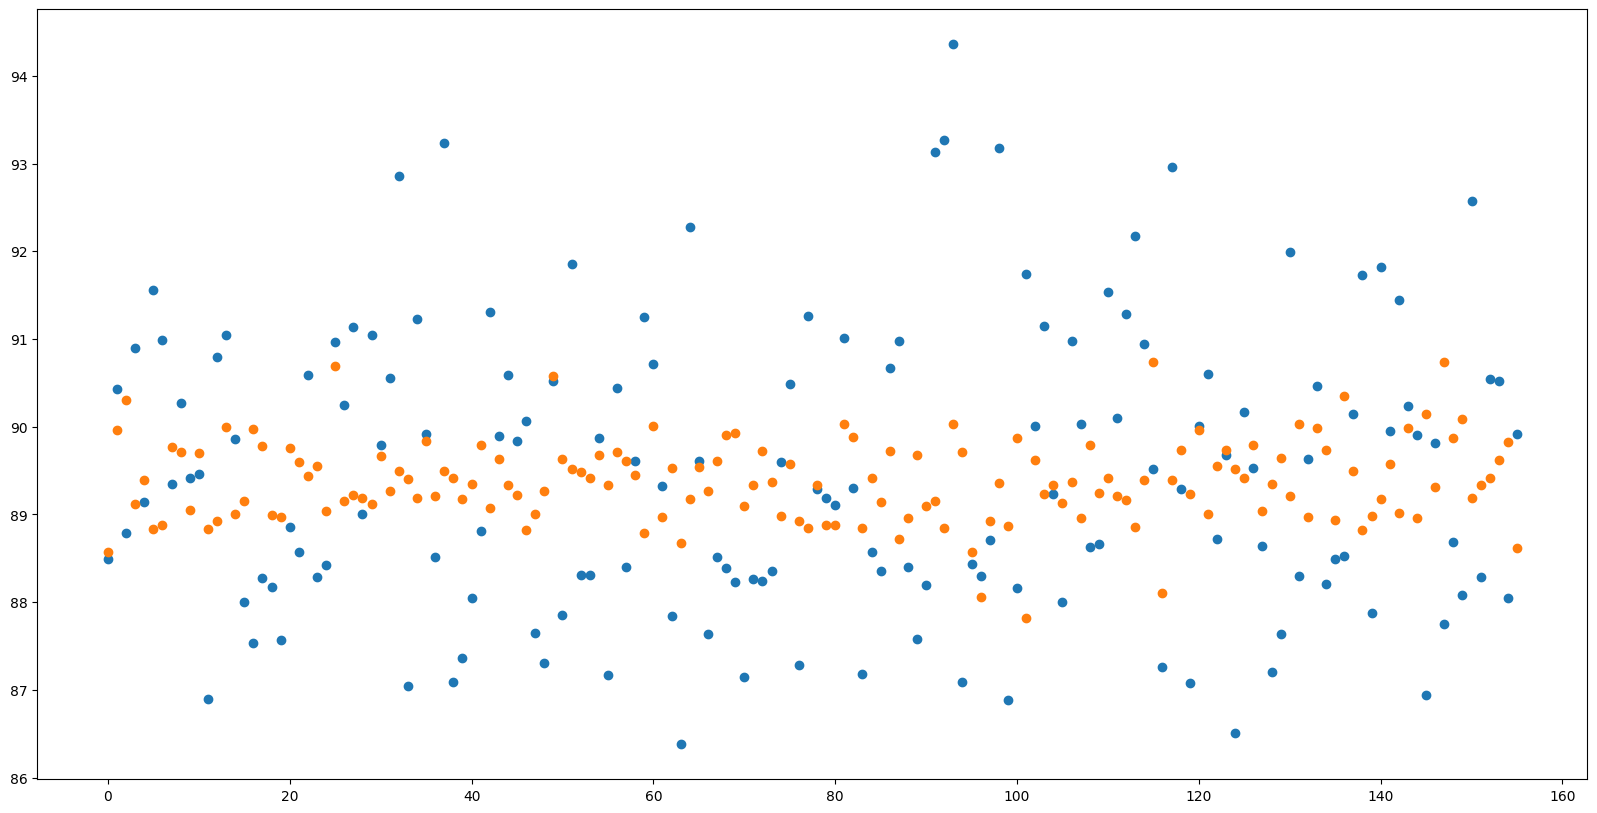

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(range(len(predictions)),targets)
ax.scatter(range(len(predictions)), predictions)
